# Building `makemore` Part 3: Activations & Gradients, BatchNorm

* Lecture: [YouTube](https://youtu.be/P6sfmUTpUmc)
* Reference paper: [Yoshua Bengio, Réjean Ducharme, Pascal Vincent, and Christian Jauvin. 2003. A Neural Probabilistic Language Model. J. Mach. Learn. Res. 3, (February 2003), 1137–1155.](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

One main difference in our implementation is that we are working with characters instead of words. The vocabulary size in the Bengio's paper is 17,000 words, whereas we are going to have a vocabulary of 27 characters (26 characters and the `<.>` special character).

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("seaborn-v0_8-whitegrid")

In [2]:
words = open("./names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vacabulary of characters and mapping to/from integers
chars = sorted(list(set("".join(words))))
s2i = {s: i + 1 for i, s in enumerate(chars)}
s2i["."] = 0
i2s = {i: s for s, i in s2i.items()}
vocab_size = len(i2s)
print(i2s)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    x, y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = s2i[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]  # crop and append

    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_trn, y_trn = build_dataset(words[:n1])  # 80%
x_val, y_val = build_dataset(words[n1:n2])  # 10%
x_tst, y_tst = build_dataset(words[n2:])  # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size), generator=g)

parameters = [C, W1, b1, W2, b2]
print(
    f"Number of trainable parameters: {sum(p.nelement() for p in parameters)}"
)  # total number of parameters in the model

for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 11897


In [7]:
max_steps = 200_000
bs = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (bs,), generator=g)
    xb, yb = x_trn[ix], y_trn[ix]

    # forward pass
    emb = C[xb]  # embed the characters into vectors
    emb_cat = emb.view((emb.shape[0], -1))  # concat the vectors
    h_pre_act = emb_cat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(h_pre_act)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.9417
  20000/ 200000: 2.5795
  30000/ 200000: 2.7819
  40000/ 200000: 2.0216
  50000/ 200000: 2.5858
  60000/ 200000: 2.3217
  70000/ 200000: 2.1007
  80000/ 200000: 2.2893
  90000/ 200000: 2.2368
 100000/ 200000: 1.9774
 110000/ 200000: 2.4507
 120000/ 200000: 1.9623
 130000/ 200000: 2.3657
 140000/ 200000: 2.2424
 150000/ 200000: 2.1469
 160000/ 200000: 2.2506
 170000/ 200000: 1.7543
 180000/ 200000: 2.1055
 190000/ 200000: 1.8174


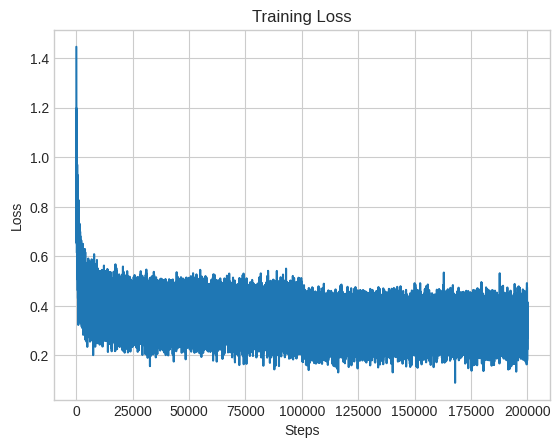

In [8]:
plt.plot(lossi)
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Steps")
plt.show()

In [9]:
@torch.no_grad()  # this decorator disable gradient tracking
def split_loss(split: str):
    x, y = {
        "train": (x_trn, y_trn),
        "val": (x_val, y_val),
        "test": (x_tst, y_tst),
    }[split]
    emb = C[x]  # (bs, block_size, n_embd)
    emb_cat = emb.view((emb.shape[0], -1))  # concat into (bs, block_size * n_embd)
    h_pre_act = emb_cat @ W1 + b1  # (bs, n_hidden)
    h = torch.tanh(h_pre_act)  # (bs, n_hidden)
    logits = h @ W2 + b2  # (bs, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.126697540283203
val 2.171041250228882


In [10]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass of the neural network
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if the special "." token break
        if ix == 0:
            break

    print("".join(i2s[i] for i in out))

mona.
mayah.
see.
mel.
ryllo.
emmadiengramira.
eredielin.
shy.
jen.
eden.
eson.
arleiyah.
hone.
cayshubergihimier.
kendreelynn.
nochorius.
macder.
yaque.
ehs.
kayjahsin.


## Debugging: The logits

The loss we have after the first forward pass is too high, which is a red flag. This could have been caused by a poor initialization. We would expect an initial loss closer to $ - \log{\frac{1}{\text{vocab. lenght}}} = - \log{\frac{1}{27}} $. 

In [11]:
-torch.tensor(1 / 27).log()

tensor(3.2958)

To better understand what is happening, let's use an example using 4 classes.

In [12]:
# 4-d example of the issue
logits = torch.randn(4)
y_true = torch.tensor([0.0, 0.0, 1.0, 0.0])
loss = F.cross_entropy(input=logits, target=y_true)
print(f"logits: {logits}\nloss: {loss}")

logits: tensor([-0.2679,  1.9819, -0.6744,  0.0919])
loss: 2.938995122909546


In [13]:
# 4-d example of the issue
logits = torch.randn(4) * 10  # <-- artificially increase the values of the logits
y_true = torch.tensor([0.0, 0.0, 1.0, 0.0])
loss = F.cross_entropy(input=logits, target=y_true)
print(f"logits: {logits}\nloss: {loss}")

logits: tensor([13.2180,  8.0320, 13.2627, -3.0811])
loss: 0.6738167405128479


What is happening is that the logits generated by our model are too extreme at the beginning of the training process. This causes the loss to become extremely large in those cases when we are very confidently wrong (e.g., high logit for the wrong class, and low logits for the other classes). 

Let's inspect the logits after the first forward pass.

In [14]:
# MLP
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size), generator=g)

parameters = [C, W1, b1, W2, b2]
print(
    f"Number of trainable parameters: {sum(p.nelement() for p in parameters)}"
)  # total number of parameters in the model

for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 11897


In [15]:
max_steps = 200_000
bs = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (bs,), generator=g)
    xb, yb = x_trn[ix], y_trn[ix]

    # forward pass
    emb = C[xb]  # embed the characters into vectors
    emb_cat = emb.view((emb.shape[0], -1))  # concat the vectors
    h_pre_act = emb_cat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(h_pre_act)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
        print(logits[0])
    lossi.append(loss.log10().item())

    break

      0/ 200000: 27.8817
tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)


To fix this, let's set `b2` to zeroes, and reduce the magnitude of the init values in the `W2` weight matrix.

In [16]:
# MLP
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  # not zero!
b2 = torch.randn((vocab_size), generator=g) * 0  # reset the bias term

parameters = [C, W1, b1, W2, b2]
print(
    f"Number of trainable parameters: {sum(p.nelement() for p in parameters)}"
)  # total number of parameters in the model

for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 11897


In [17]:
max_steps = 200_000
bs = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (bs,), generator=g)
    xb, yb = x_trn[ix], y_trn[ix]

    # forward pass
    emb = C[xb]  # embed the characters into vectors
    emb_cat = emb.view((emb.shape[0], -1))  # concat the vectors
    h_pre_act = emb_cat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(h_pre_act)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
        print(logits[0])
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.3221
tensor([-0.0249,  0.3523, -0.1267,  0.0541,  0.1662, -0.1171, -0.0140,  0.0124,
         0.0921,  0.1135,  0.1362, -0.0925,  0.0444, -0.2459, -0.0971,  0.0125,
        -0.0957, -0.1376, -0.2329, -0.0137,  0.2452,  0.1616,  0.1665, -0.1094,
        -0.2154,  0.0725,  0.1141], grad_fn=<SelectBackward0>)


This is much better, as the logits are more uniformly distributed, without extreme values. These are the logits from the very first forward pass, so it would be bad if they are heavily biased towards a particular output, as there hasn't been any learning yet (no backprop.).

Let's run the full optimization, not just the first forward pass.

In [18]:
# MLP
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  # not zero!
b2 = torch.randn((vocab_size), generator=g) * 0  # reset the bias term

parameters = [C, W1, b1, W2, b2]
print(
    f"Number of trainable parameters: {sum(p.nelement() for p in parameters)}"
)  # total number of parameters in the model

for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 11897


In [19]:
max_steps = 200_000
bs = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (bs,), generator=g)
    xb, yb = x_trn[ix], y_trn[ix]

    # forward pass
    emb = C[xb]  # embed the characters into vectors
    emb_cat = emb.view((emb.shape[0], -1))  # concat the vectors
    h_pre_act = emb_cat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(h_pre_act)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8645
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


In [20]:
@torch.no_grad()  # this decorator disable gradient tracking
def split_loss(split: str):
    x, y = {
        "train": (x_trn, y_trn),
        "val": (x_val, y_val),
        "test": (x_tst, y_tst),
    }[split]
    emb = C[x]  # (bs, block_size, n_embd)
    emb_cat = emb.view((emb.shape[0], -1))  # concat into (bs, block_size * n_embd)
    h_pre_act = emb_cat @ W1 + b1  # (bs, n_hidden)
    h = torch.tanh(h_pre_act)  # (bs, n_hidden)
    logits = h @ W2 + b2  # (bs, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.069589138031006
val 2.1310744285583496


This is a significant improvement over the previous model! The reason for that is that we are spending more cycles learning instead of using the first few thousand iteration to squash down the weights to avoid extreme logits.

## Debugging: The hidden activation states

This time we are going to focus on the values of the hidden layer activations. There are taking on very extreme values, closer to $ -1.0 $ and $ 1.0 $.

In [21]:
# MLP
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  # not zero!
b2 = torch.randn((vocab_size), generator=g) * 0  # reset the bias term

parameters = [C, W1, b1, W2, b2]
print(
    f"Number of trainable parameters: {sum(p.nelement() for p in parameters)}"
)  # total number of parameters in the model

for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 11897


In [22]:
max_steps = 200_000
bs = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (bs,), generator=g)
    xb, yb = x_trn[ix], y_trn[ix]

    # forward pass
    emb = C[xb]  # embed the characters into vectors
    emb_cat = emb.view((emb.shape[0], -1))  # concat the vectors
    h_pre_act = emb_cat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(h_pre_act)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
        print(h)
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.3221
tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)


As a reminder, the tanh function converts value in the $ [-\infty, \infty] $ to $ [-1, 1] $.

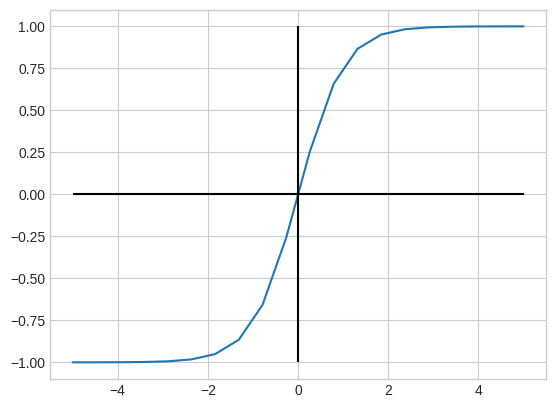

In [23]:
x = torch.linspace(-5, 5, steps=20)
y = torch.tanh(x)
plt.plot(x, y)
plt.vlines(x=0, ymin=-1, ymax=1, color="black")
plt.hlines(y=0, xmin=-5, xmax=5, color="black")
plt.show()

Unfortunately, in our case, it seems that our hidden layer activations are -1 or 1 too often, instead of being more evenly distributed.

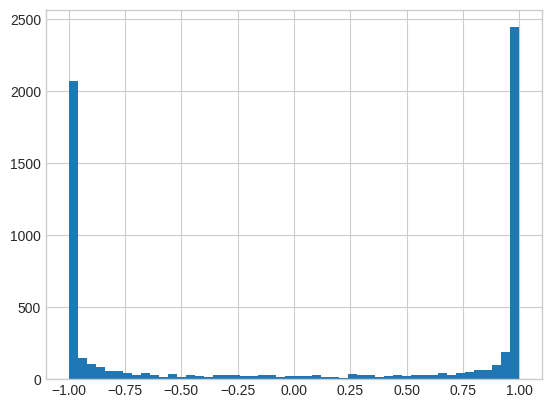

In [24]:
plt.hist(h.view(-1).tolist(), bins=50)
plt.show()

The root cause of that is the values of the hidden layer's preactivations. These are often lower than -2 or higher than 2, which correspond to value respectively very close to -1 and 1 aften passing through the tanh function.

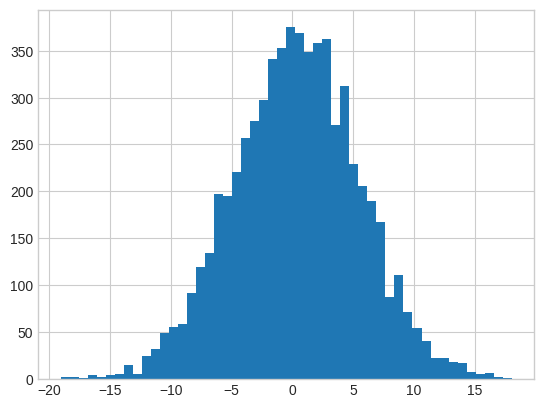

In [25]:
plt.hist(h_pre_act.view(-1).tolist(), bins=50)
plt.show()

This is very concerning as the gradient of the tanh operation is:

```python 
self.grad += (1 - t**2) * out.grad
```

As the value of $ t $ approximite 1, we are backpropagating less and less. At the limit, the gradient will be 0. The more we are in the flat tail of the tanh distribution, the more the gradient is closer to zero. Intuitively, smaller changes of the input will not change the output. See the plot of the distribution to verify that.

This is an example of a "vanishing gradient" issue. Conversely, when the tanh is equal to 0, the gradient pass-through.

There are, however, some redeeming qualities. We would be in trouble in an entire column in the following graph was white ― which is not the case. If that was true, we would have a "dead neuron". Dead neurons are neurons where the initialization of the weights and biases are such that that no single example ever activates this tanh in the active part of the tanh. If all of the examples land in the tails of the tanh, this neuron will never learn, it is a "dead neuron".

Note that this phenomenon can happens also for other activations, not just tanh.

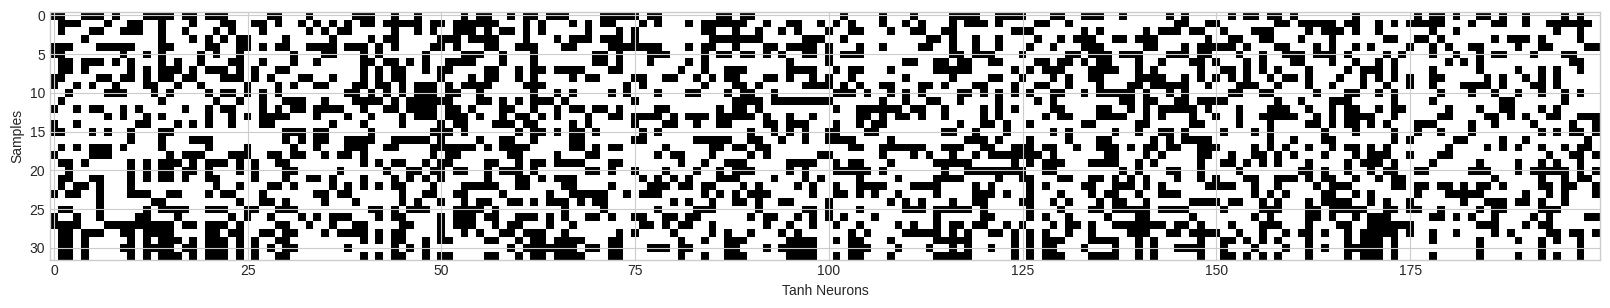

In [26]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")
plt.xlabel("Tanh Neurons")
plt.ylabel("Samples")
plt.show()

Importantly, here we are only looking at the first batch. If a white column would appear in the first batch, we would still have to inspect the rest of the samples in our training set. It could be that the neuron is inactive only for one batch, but active in others. A "dead neuron" is a sort of permanent brain damage.

Even if the "dead neuron" issue is not occurring, we are still not happy with the distribution above ― especially after initialization. All of these extreme value in the hidden layer activation cause the network to not learning as much. 

To fix the issue, we are going to multiply both `W1` by 0.2 and `b1` by 0.01. 

In [27]:
# MLP
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  # not zero!
b2 = torch.randn((vocab_size), generator=g) * 0  # reset the bias term

parameters = [C, W1, b1, W2, b2]
print(
    f"Number of trainable parameters: {sum(p.nelement() for p in parameters)}"
)  # total number of parameters in the model

for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 11897


In [28]:
max_steps = 200_000
bs = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (bs,), generator=g)
    xb, yb = x_trn[ix], y_trn[ix]

    # forward pass
    emb = C[xb]  # embed the characters into vectors
    emb_cat = emb.view((emb.shape[0], -1))  # concat the vectors
    h_pre_act = emb_cat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(h_pre_act)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
        print(h)
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.3135
tensor([[ 0.5503, -0.1064, -0.6658,  ..., -0.3477, -0.9756,  0.8880],
        [-0.9081, -0.1924, -0.1833,  ...,  0.0494,  0.4942,  0.4397],
        [ 0.8016,  0.1173,  0.8237,  ...,  0.2890,  0.6476,  0.8827],
        ...,
        [-0.9190,  0.5208, -0.0346,  ..., -0.0830,  0.8660,  0.8849],
        [-0.9362,  0.0930, -0.2810,  ..., -0.1260,  0.7874,  0.9102],
        [-0.9190,  0.5208, -0.0346,  ..., -0.0830,  0.8660,  0.8849]],
       grad_fn=<TanhBackward0>)


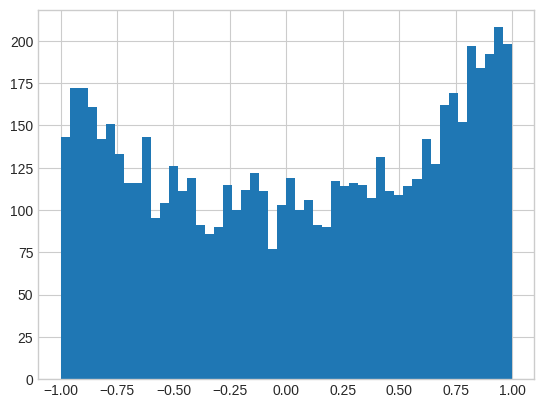

In [29]:
plt.hist(h.view(-1).tolist(), bins=50)
plt.show()

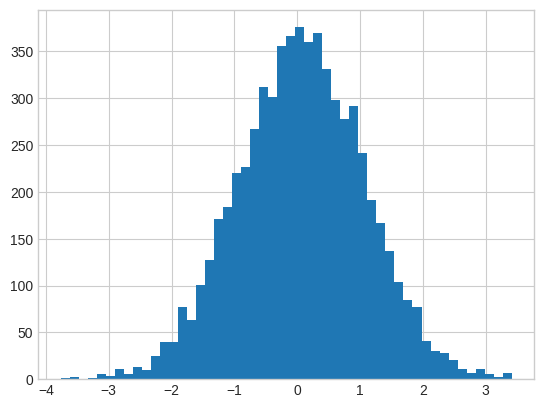

In [30]:
plt.hist(h_pre_act.view(-1).tolist(), bins=50)
plt.show()

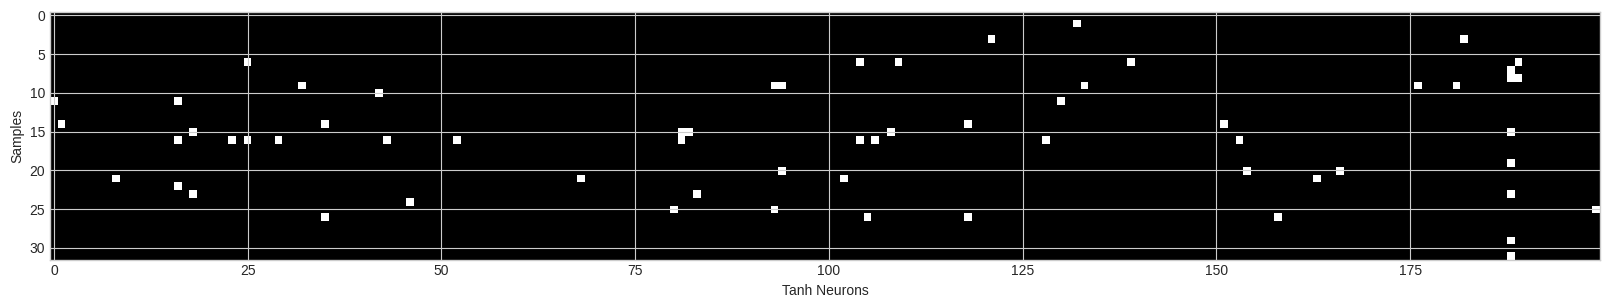

In [31]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")
plt.xlabel("Tanh Neurons")
plt.ylabel("Samples")
plt.show()

Now let's train the network with these fixes in place. 

In [32]:
# MLP
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  # not zero!
b2 = torch.randn((vocab_size), generator=g) * 0  # reset the bias term

parameters = [C, W1, b1, W2, b2]
print(
    f"Number of trainable parameters: {sum(p.nelement() for p in parameters)}"
)  # total number of parameters in the model

for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 11897


In [33]:
max_steps = 200_000
bs = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (bs,), generator=g)
    xb, yb = x_trn[ix], y_trn[ix]

    # forward pass
    emb = C[xb]  # embed the characters into vectors
    emb_cat = emb.view((emb.shape[0], -1))  # concat the vectors
    h_pre_act = emb_cat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(h_pre_act)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


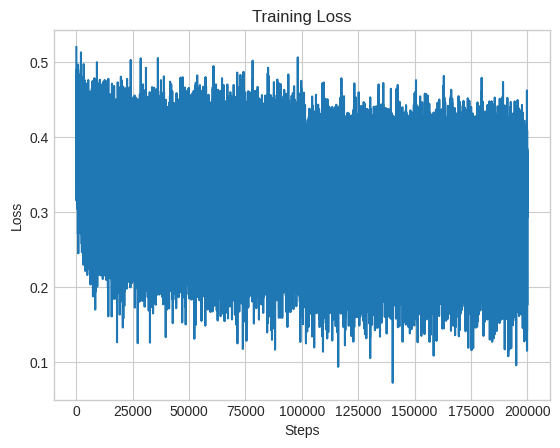

In [34]:
plt.plot(lossi)
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Steps")
plt.show()

In [35]:
@torch.no_grad()  # this decorator disable gradient tracking
def split_loss(split: str):
    x, y = {
        "train": (x_trn, y_trn),
        "val": (x_val, y_val),
        "test": (x_tst, y_tst),
    }[split]
    emb = C[x]  # (bs, block_size, n_embd)
    emb_cat = emb.view((emb.shape[0], -1))  # concat into (bs, block_size * n_embd)
    h_pre_act = emb_cat @ W1 + b1  # (bs, n_hidden)
    h = torch.tanh(h_pre_act)  # (bs, n_hidden)
    logits = h @ W2 + b2  # (bs, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.0355963706970215
val 2.1026782989501953


As we can see, we were able to make some improvements by fixing the softmax overconfidence issue, and the saturation of the tanh layer. Despite that, the original model was not too bad. This is the case because we are working with a very shallow network. If we were working with a much deeper network, of say 50 layers, these problems will stack up and getting to a place where the network is not learning anything if the init is bad enough. The deeper the network is, the least forgiving it is.

In [36]:
# loss log

# original:
# train 2.126697540283203
# val 2.171041250228882

# fix softmax confidently wrong:
# train 2.069589138031006
# val 2.1310744285583496

# fix tanh layer too saturated at init:
# train 2.0355963706970215
# val 2.1026782989501953

In [37]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass of the neural network
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if the special "." token break
        if ix == 0:
            break

    print("".join(i2s[i] for i in out))

mora.
mayah.
see.
mad.
ryll.
renvestendraegusteredielin.
shi.
jen.
edeiseananar.
kayzion.
kamin.
shubergianaiya.
kinde.
jennex.
teron.
ububynder.
yarue.
els.
kayshaykella.
hal.


### How did we came up with those scaling factors?

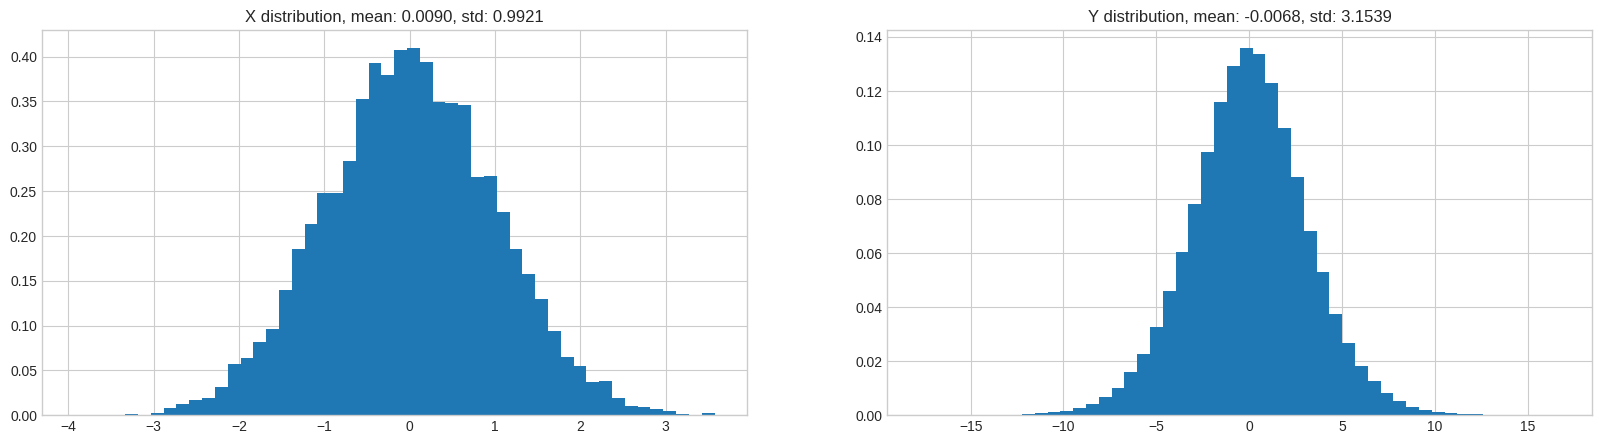

In [38]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.title(f"X distribution, mean: {x.mean():.4f}, std: {x.std():.4f}")
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
plt.title(f"Y distribution, mean: {y.mean():.4f}, std: {y.std():.4f}")
plt.show()

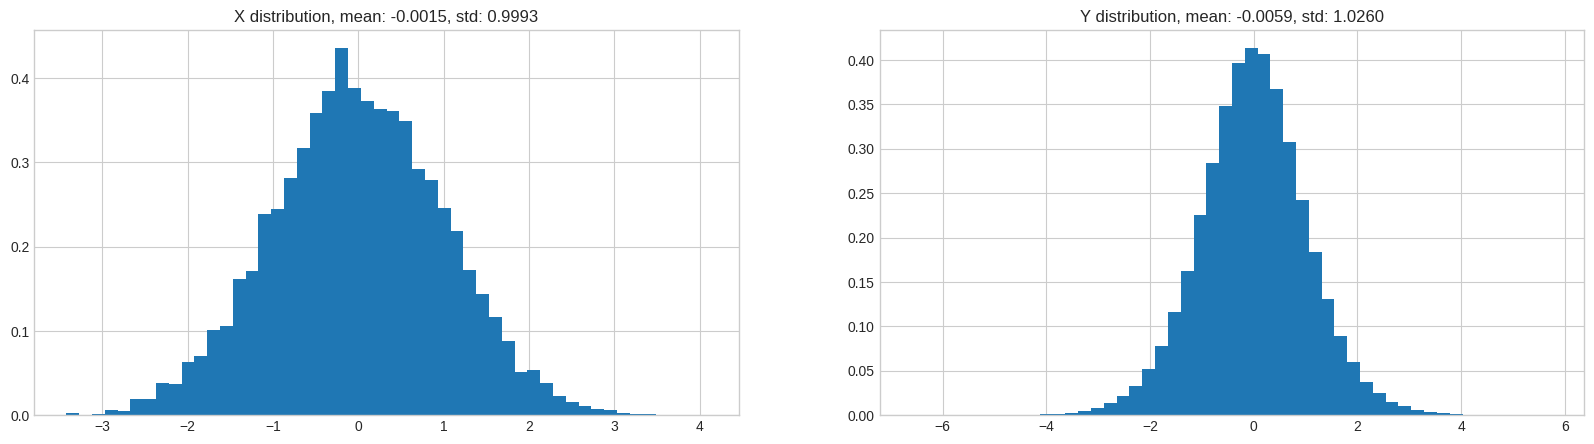

In [39]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.title(f"X distribution, mean: {x.mean():.4f}, std: {x.std():.4f}")
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
plt.title(f"Y distribution, mean: {y.mean():.4f}, std: {y.std():.4f}")
plt.show()

The paper [Delving Deep into Rectifiers, He et. al.](https://arxiv.org/abs/1502.01852) investigates how to best initialize these networks, particularly for ReLU and PReLU non-linearities. But the analysis would be very similar for other non-linearities. This initialization is very common nowadays, and implemented in PyTorch with the [`torch.nn.init.kaiming_normal_`](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_) function.

What we did above was to implement something similar to the Kaiming He init. 

In [40]:
gain = (
    5 / 3
)  # https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain
fan_in = n_embd * block_size

std = gain / (fan_in**0.5)
std

0.3042903097250923

Let's try to use the real thing.

In [41]:
# MLP
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embd * block_size) ** 0.5)
)
b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * (5 / 3) / ((n_hidden) ** 0.5)
b2 = torch.randn((vocab_size), generator=g) * 0  # reset the bias term

parameters = [C, W1, b1, W2, b2]
print(
    f"Number of trainable parameters: {sum(p.nelement() for p in parameters)}"
)  # total number of parameters in the model

for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 11897


In [42]:
max_steps = 200_000
bs = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (bs,), generator=g)
    xb, yb = x_trn[ix], y_trn[ix]

    # forward pass
    emb = C[xb]  # embed the characters into vectors
    emb_cat = emb.view((emb.shape[0], -1))  # concat the vectors
    h_pre_act = emb_cat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(h_pre_act)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 4.1627
  10000/ 200000: 2.1838
  20000/ 200000: 2.3984
  30000/ 200000: 2.4408
  40000/ 200000: 1.9492
  50000/ 200000: 2.3230
  60000/ 200000: 2.4580
  70000/ 200000: 2.1214
  80000/ 200000: 2.3010
  90000/ 200000: 2.2164
 100000/ 200000: 1.8441
 110000/ 200000: 2.1224
 120000/ 200000: 1.8953
 130000/ 200000: 2.4402
 140000/ 200000: 2.0976
 150000/ 200000: 2.1316
 160000/ 200000: 1.8384
 170000/ 200000: 1.8277
 180000/ 200000: 1.8689
 190000/ 200000: 1.8078


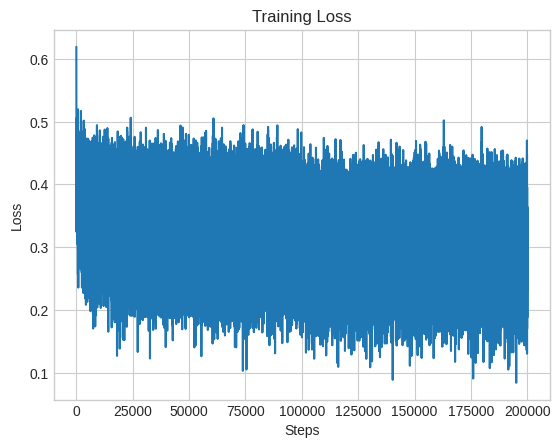

In [43]:
plt.plot(lossi)
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Steps")
plt.show()

In [44]:
@torch.no_grad()  # this decorator disable gradient tracking
def split_loss(split: str):
    x, y = {
        "train": (x_trn, y_trn),
        "val": (x_val, y_val),
        "test": (x_tst, y_tst),
    }[split]
    emb = C[x]  # (bs, block_size, n_embd)
    emb_cat = emb.view((emb.shape[0], -1))  # concat into (bs, block_size * n_embd)
    h_pre_act = emb_cat @ W1 + b1  # (bs, n_hidden)
    h = torch.tanh(h_pre_act)  # (bs, n_hidden)
    logits = h @ W2 + b2  # (bs, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.037997007369995
val 2.1054441928863525


In [45]:
# loss log

# original:
# train 2.126697540283203
# val 2.171041250228882

# fix softmax confidently wrong:
# train 2.069589138031006
# val 2.1310744285583496

# fix tanh layer too saturated at init:
# train 2.0355963706970215
# val 2.1026782989501953

# kaiming normal
# train 2.037997007369995
# val 2.1054441928863525

We roughly got to the same place, but without using "magic numbers". That's a win!

In [46]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass of the neural network
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if the special "." token break
        if ix == 0:
            break

    print("".join(i2s[i] for i in out))

mora.
mayah.
seel.
ndyn.
aleren.
ruthndraegan.
eledgelin.
shi.
jen.
eden.
estanaraelyzion.
kamin.
shub.
roshiriel.
kin.
renlynn.
novana.
ubrence.
ryyah.
fael.


## Batch Normalization

Ref.: [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
, Ioffe et. al.](https://arxiv.org/abs/1502.03167)

The intuition is that we want `h_pre_act` to be gaussian, before passing them to the activation function, at least after initialization. So, why not implementing a layer that does just that?

Again, if the `h_pre_act` are to close to 0, they are inactive, if too close to -1 or 1, they are too saturated.

In [47]:
# MLP
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embd * block_size) ** 0.5)
)
# b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * (5 / 3) / ((n_hidden) ** 0.5)
b2 = torch.randn((vocab_size), generator=g) * 0  # reset the bias term

# batch norm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(
    f"Number of trainable parameters: {sum(p.nelement() for p in parameters)}"
)  # total number of parameters in the model

for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 12097


In [48]:
max_steps = 200_000
bs = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (bs,), generator=g)
    xb, yb = x_trn[ix], y_trn[ix]

    # forward pass
    emb = C[xb]  # embed the characters into vectors
    emb_cat = emb.view((emb.shape[0], -1))  # concat the vectors
    h_pre_act = emb_cat @ W1  # + b1  # hidden layer pre-activation

    # --> BATCH NORM <--
    bnmean_i = h_pre_act.mean(0, keepdim=True)
    bnstd_i = h_pre_act.std(0, keepdim=True)
    h_pre_act = bngain * (h_pre_act - bnmean_i) / bnstd_i + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean_i
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd_i
    # --> BATCH NORM <--

    h = torch.tanh(h_pre_act)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 4.1357
  10000/ 200000: 2.0278
  20000/ 200000: 2.6558
  30000/ 200000: 2.0230
  40000/ 200000: 2.2787
  50000/ 200000: 1.8606
  60000/ 200000: 2.0680
  70000/ 200000: 2.3552
  80000/ 200000: 2.3466
  90000/ 200000: 2.1315
 100000/ 200000: 2.3130
 110000/ 200000: 2.2493
 120000/ 200000: 1.6537
 130000/ 200000: 1.9163
 140000/ 200000: 2.2877
 150000/ 200000: 1.9321
 160000/ 200000: 2.0254
 170000/ 200000: 2.3684
 180000/ 200000: 2.0840
 190000/ 200000: 2.0807


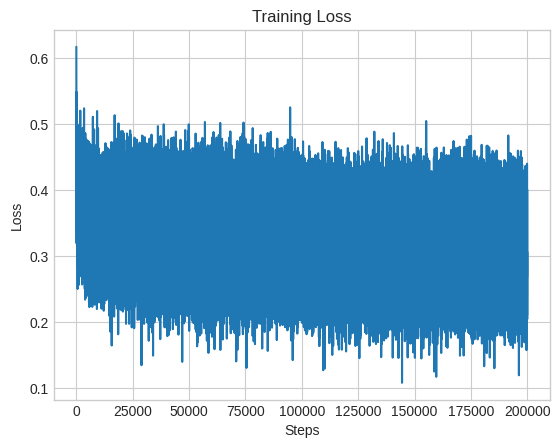

In [49]:
plt.plot(lossi)
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Steps")
plt.show()

In [50]:
@torch.no_grad()  # this decorator disable gradient tracking
def split_loss(split: str):
    x, y = {
        "train": (x_trn, y_trn),
        "val": (x_val, y_val),
        "test": (x_tst, y_tst),
    }[split]
    emb = C[x]  # (bs, block_size, n_embd)
    emb_cat = emb.view((emb.shape[0], -1))  # concat into (bs, block_size * n_embd)
    h_pre_act = emb_cat @ W1  # + b1  # (bs, n_hidden)

    # --> BATCH NORM <--
    h_pre_act = bngain * (h_pre_act - bnmean_running) / bnstd_running + bnbias
    # --> BATCH NORM <--

    h = torch.tanh(h_pre_act)  # (bs, n_hidden)
    logits = h @ W2 + b2  # (bs, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.0711417198181152
val 2.11014461517334


In [51]:
# loss log

# original:
# train 2.126697540283203
# val 2.171041250228882

# fix softmax confidently wrong:
# train 2.069589138031006
# val 2.1310744285583496

# fix tanh layer too saturated at init:
# train 2.0355963706970215
# val 2.1026782989501953

# kaiming normal
# train 2.037997007369995
# val 2.1054441928863525

# batch norm
# train 2.0711417198181152
# val 2.11014461517334

We were not expecting a large improvement on this specific network, because the network is very shallow and through a better init we were already able to achieve a gaussian shape for the pre-activations. This however is much more important for very deep networks.

In [52]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass of the neural network
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        emb_cat = emb.view((emb.shape[0], -1))  # concat into (bs, block_size * n_embd)
        h_pre_act = emb_cat @ W1  # + b1  # (bs, n_hidden)

        # --> BATCH NORM <--
        h_pre_act = bngain * (h_pre_act - bnmean_running) / bnstd_running + bnbias
        # --> BATCH NORM <--

        h = torch.tanh(h_pre_act)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if the special "." token break
        if ix == 0:
            break

    print("".join(i2s[i] for i in out))

mona.
mayah.
see.
madhayla.
rethruthadrie.
cadee.
daelin.
shi.
jen.
eden.
sananar.
kayzion.
kamin.
shub.
roshirael.
kindreelynn.
novana.
ubrence.
ryyah.
fael.


One "downside" of batch norm is that it introduces an extra dependency to compute the normalized `h_pre_act`. This dependency is every other value in the batch. Because we need all of these values to compute the mean and std of the batch that we will use to normalize the inputs.

On the other hand, this act as a regularization term as it pads out any of these input examples adding a little bit of entropy, so it makes it harder for the neural network to overfit to any of these specific examples.

Notes:
* The 0.001 we use in the running mean and std computation is called "momentum". Andrej's suggestion is to increase slightly this value if we have very large batch sizes, since the variability across different batches of the statistics we are tracking will be relatively stable. With small batch sizes, there might be more variation from one batch to the other, and therefore is recommended to use a smaller momentum.
* We didn't add the $ \epsilon $ term in the normalization operation. This is used to prevent division by 0. 
* We have also been wasteful because be could have removed the `b1` term, as the network can learn that while learning the `bnbias` term. Basically, if we remove entirely the bias in the preceeding layer (e.g., `b1`), the new `bnbias` would be learned as `bnbias + b1`.

## Pytorch-ifying the code

In [53]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [54]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

In [55]:
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [56]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
loss_i = []
ud = []  # update:data ratio

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (batch_size,), generator=g)
    xb, yx = x_trn[ix], y_trn[ix]

    # forward pass
    emb = C[xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # ATFER DEBUG: would take out retain_grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )

    break  # AFTER DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3109


layer 1 Tanh: mean -0.02, std 0.75, saturated: 20.25
layer 3 Tanh: mean -0.00, std 0.69, saturated: 8.38
layer 5 Tanh: mean 0.00, std 0.67, saturated: 6.62
layer 7 Tanh: mean -0.01, std 0.66, saturated: 5.47
layer 9 Tanh: mean -0.02, std 0.66, saturated: 6.12


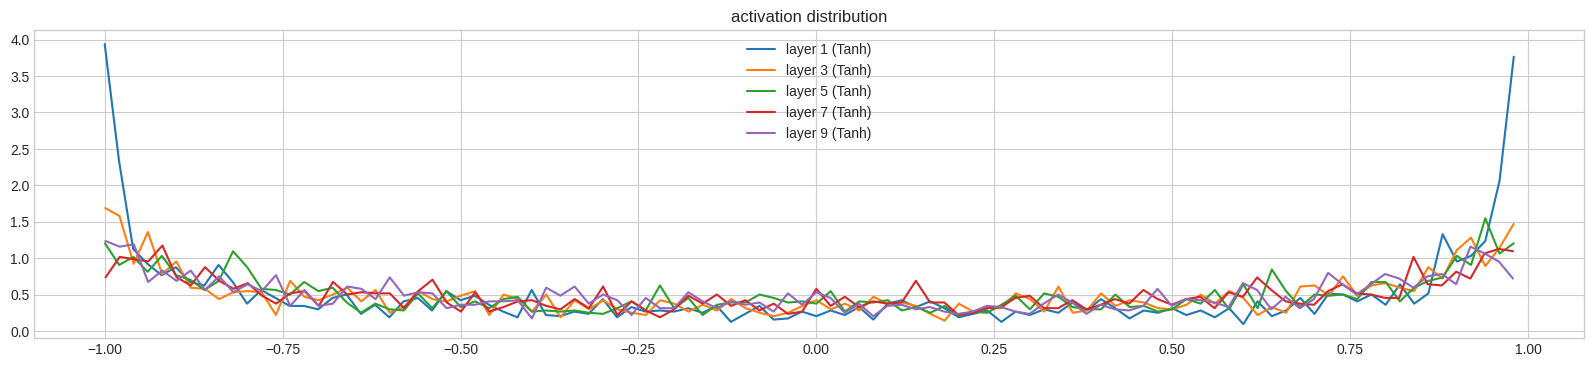

In [57]:
# visualize histogram
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            f"layer {i} {layer.__class__.__name__}: mean {t.mean():.2f}, std {t.std():.2f}, saturated: {(t.abs() > 0.97).float().mean()*100:.2f}"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")
plt.show()

From the graph above we can see that the first layer is quite saturated, but the other layers are okay. As we add more layers, we would see that the std of each layer will converge to 0.65 and the saturation at around 5%, because of the "gain" that we set to 5/3.

If we were not using any gain (e.g., 1), the std of the layers would be shrinking and the saturation will converge to zero. 

A higher gain (e.g., 3), would cause much higher saturation across all layers (above 40%).

We need a gain because the tanh layers are "squashing" functions. They take an input ranging from $ [ -\infty, \infty ]$, and return an output ranging from $ [ -1, 1] $. If we don't apply any gain, the std will converge to 0. The gain is basically trying to fight the squashing.

Empirically, 5/3 is a good gain for a sandwich of Linear and Tanh layers. The 5/3 value is also the gain PyTorch uses when initializing networks with Tanh layers using Kaiming Normal init.

layer 1 Tanh: mean -0.00, std 0.00, saturated: 0.00
layer 3 Tanh: mean -0.00, std 0.00, saturated: 0.00
layer 5 Tanh: mean 0.00, std 0.00, saturated: 0.00
layer 7 Tanh: mean 0.00, std 0.00, saturated: 0.00
layer 9 Tanh: mean -0.00, std 0.00, saturated: 0.00


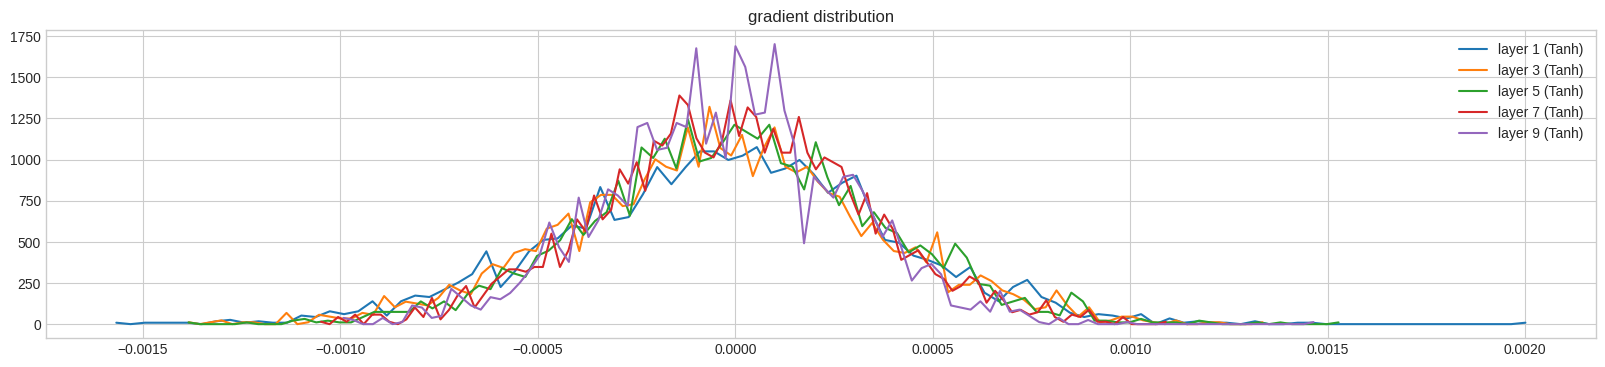

In [58]:
# visualize histogram
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            f"layer {i} {layer.__class__.__name__}: mean {t.mean():.2f}, std {t.std():.2f}, saturated: {(t.abs() > 0.97).float().mean()*100:.2f}"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("gradient distribution")
plt.show()

weight (27, 10): mean -0.000158, std 0.001334, grad:data ratio: 0.001333
weight (30, 100): mean -0.000034, std 0.001540, grad:data ratio: 0.004938
weight (100, 100): mean -0.000001, std 0.001225, grad:data ratio: 0.007372
weight (100, 100): mean -0.000010, std 0.001038, grad:data ratio: 0.006180
weight (100, 100): mean 0.000009, std 0.000901, grad:data ratio: 0.005387
weight (100, 100): mean 0.000010, std 0.000800, grad:data ratio: 0.004781
weight (100, 27): mean -0.000000, std 0.023667, grad:data ratio: 2.342432


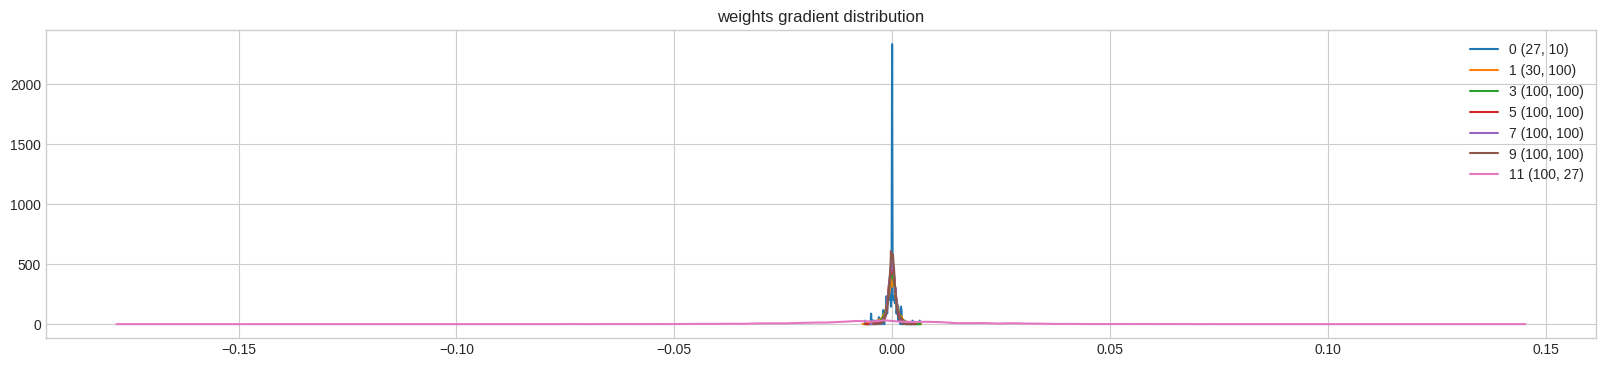

In [59]:
# visualize histogram
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            f"weight {tuple(p.shape)}: mean {t.mean():.6f}, std {t.std():.6f}, grad:data ratio: {t.std() / p.std():.6f}"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(t.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution")
plt.show()

The grad:data ratio gives you a sense of what is the scale of the gradient compared to the scale of the actual value. This is important because we are going to take a step update that is the lr times the gradient on to the data. If the gradient has a too large magnitude compared to the numbers in the data (the weight), than you would be in trouble. 

It seems that all values are okay, aside from the last layer, which has gradients on a magnitude much larger (20x) than the gradients on the other layers ― std 0.023 vs 0.001. This is an issue because when we are using SGD, we would be training this layer about 20x faster than the other layers at initialization. After about 1000 steps of optimization, this seems to be fixing itself, but it is nonetheless inefficient.

In [60]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

In [61]:
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [62]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
loss_i = []
ud = []  # update:data ratio

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (batch_size,), generator=g)
    xb, yx = x_trn[ix], y_trn[ix]

    # forward pass
    emb = C[xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # ATFER DEBUG: would take out retain_grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )

    if i >= 1000:
        break  # AFTER DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3109


weight (27, 10): mean 0.000031, std 0.001541, grad:data ratio: 0.001543
weight (30, 100): mean -0.000050, std 0.001309, grad:data ratio: 0.004203
weight (100, 100): mean -0.000006, std 0.001209, grad:data ratio: 0.007284
weight (100, 100): mean -0.000002, std 0.001037, grad:data ratio: 0.006178
weight (100, 100): mean -0.000015, std 0.000932, grad:data ratio: 0.005577
weight (100, 100): mean -0.000009, std 0.000907, grad:data ratio: 0.005416
weight (100, 27): mean 0.000000, std 0.006982, grad:data ratio: 0.161001


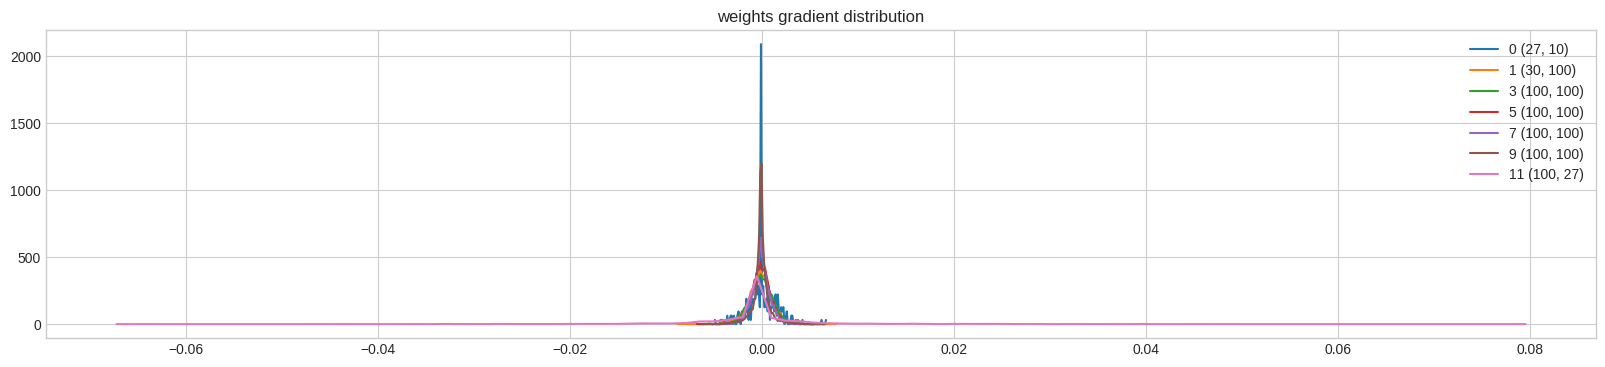

In [63]:
# visualize histogram
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            f"weight {tuple(p.shape)}: mean {t.mean():.6f}, std {t.std():.6f}, grad:data ratio: {t.std() / p.std():.6f}"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(t.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution")
plt.show()

A more interesting graph is the evolution of the update ratio over time. 

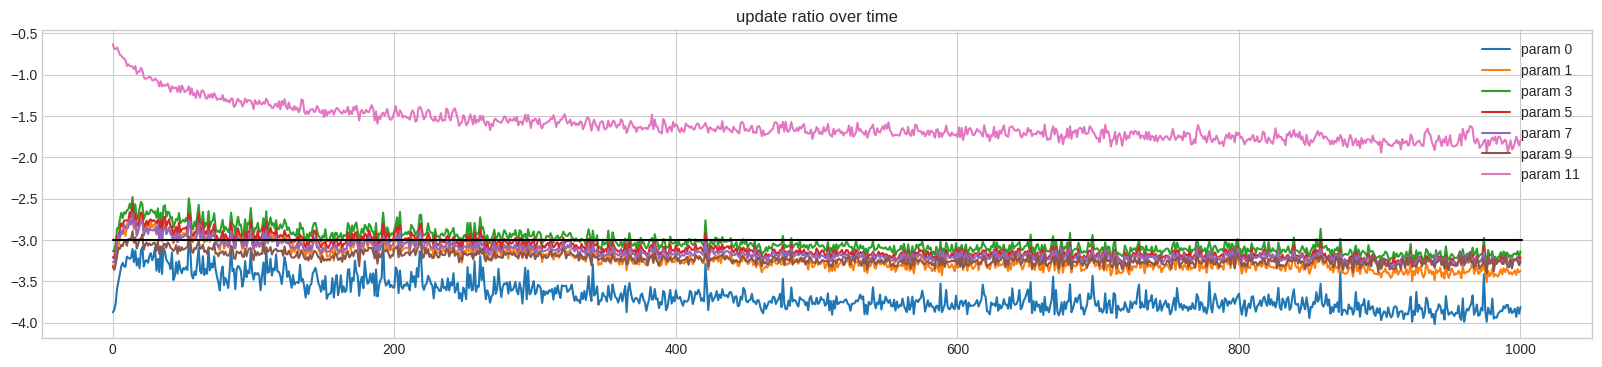

In [64]:
# visualize histogram
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"param {i}")
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.title("update ratio over time")
plt.show()

Karpathy says that we generally do not want the magnitude of the weight update to be larger than 1/1000 of the magnitude of the weight we want to update ― hence the 1e-3 number on the previous code snippet. Everything under the black line is generally good.

What causes the issue on the last layer is that we multiplied the weights on the final layer by 0.1 to keep the softmax from becoming overconfident.

Karpathy also uses this graph to set the learning rate. If the update ratio is much lower that 1/1000, we should increase the learning rate.

#### Adding BatchNorm

In [65]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
    BatchNorm1d(vocab_size),
]

In [66]:
with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1  # instead of layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0  # 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [67]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
loss_i = []
ud = []  # update:data ratio

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (batch_size,), generator=g)
    xb, yx = x_trn[ix], y_trn[ix]

    # forward pass
    emb = C[xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # ATFER DEBUG: would take out retain_grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )

    if i >= 1000:
        break  # AFTER DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3249


layer 2 Tanh: mean -0.002326, std 0.633054, saturated: 2.69%
layer 5 Tanh: mean 0.004783, std 0.636317, saturated: 2.50%
layer 8 Tanh: mean -0.004636, std 0.637255, saturated: 2.41%
layer 11 Tanh: mean -0.002094, std 0.639532, saturated: 2.44%
layer 14 Tanh: mean 0.002175, std 0.634005, saturated: 2.56%


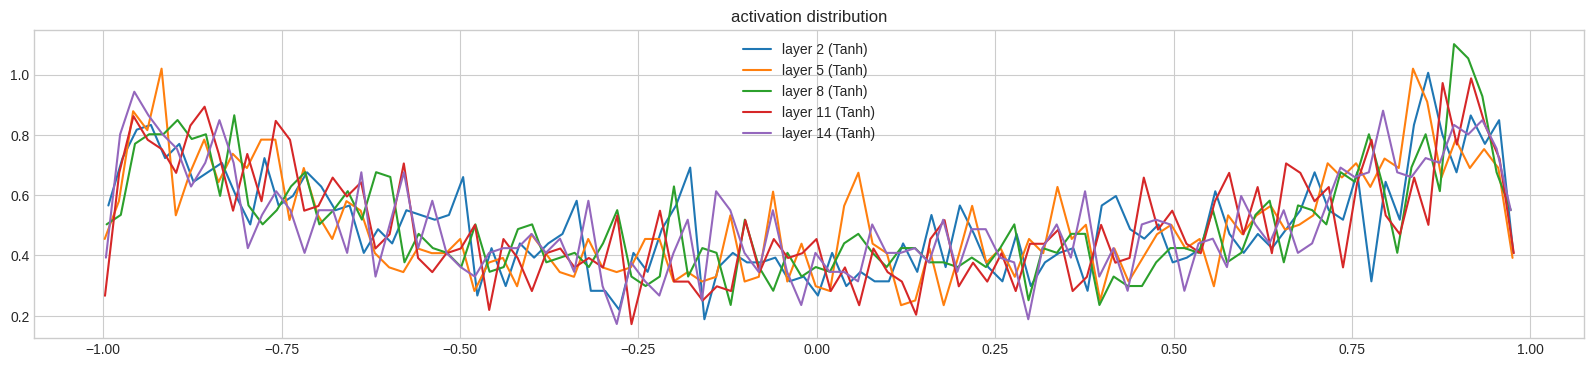

In [68]:
# visualize histogram
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            f"layer {i} {layer.__class__.__name__}: mean {t.mean():.6f}, std {t.std():.6f}, saturated: {(t.abs() > 0.97).float().mean()*100:.2f}%"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")
plt.show()

layer 2 Tanh: mean -0.000000, std 0.000225, saturated: 0.00%
layer 5 Tanh: mean 0.000000, std 0.000187, saturated: 0.00%
layer 8 Tanh: mean 0.000000, std 0.000169, saturated: 0.00%
layer 11 Tanh: mean -0.000000, std 0.000153, saturated: 0.00%
layer 14 Tanh: mean 0.000000, std 0.000149, saturated: 0.00%


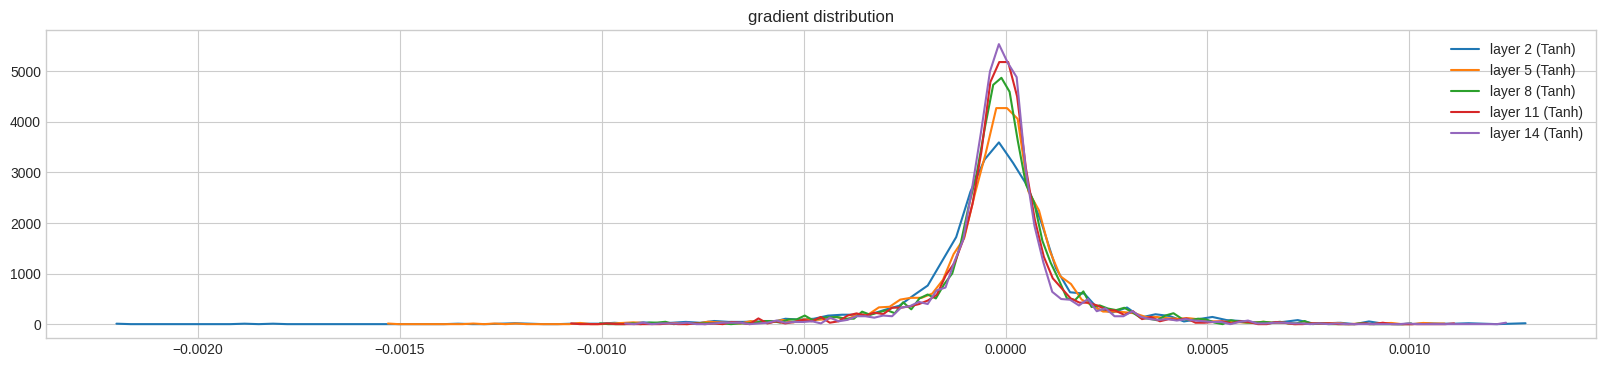

In [69]:
# visualize histogram
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            f"layer {i} {layer.__class__.__name__}: mean {t.mean():.6f}, std {t.std():.6f}, saturated: {(t.abs() > 0.97).float().mean()*100:.2f}%"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("gradient distribution")
plt.show()

weight (27, 10): mean 0.000000, std 0.000473, grad:data ratio: 0.000473
weight (30, 100): mean -0.000000, std 0.000768, grad:data ratio: 0.004102
weight (100, 100): mean 0.000001, std 0.000740, grad:data ratio: 0.007421
weight (100, 100): mean -0.000001, std 0.000633, grad:data ratio: 0.006283
weight (100, 100): mean -0.000008, std 0.000586, grad:data ratio: 0.005838
weight (100, 100): mean -0.000001, std 0.000525, grad:data ratio: 0.005222
weight (100, 27): mean -0.000023, std 0.001001, grad:data ratio: 0.010116


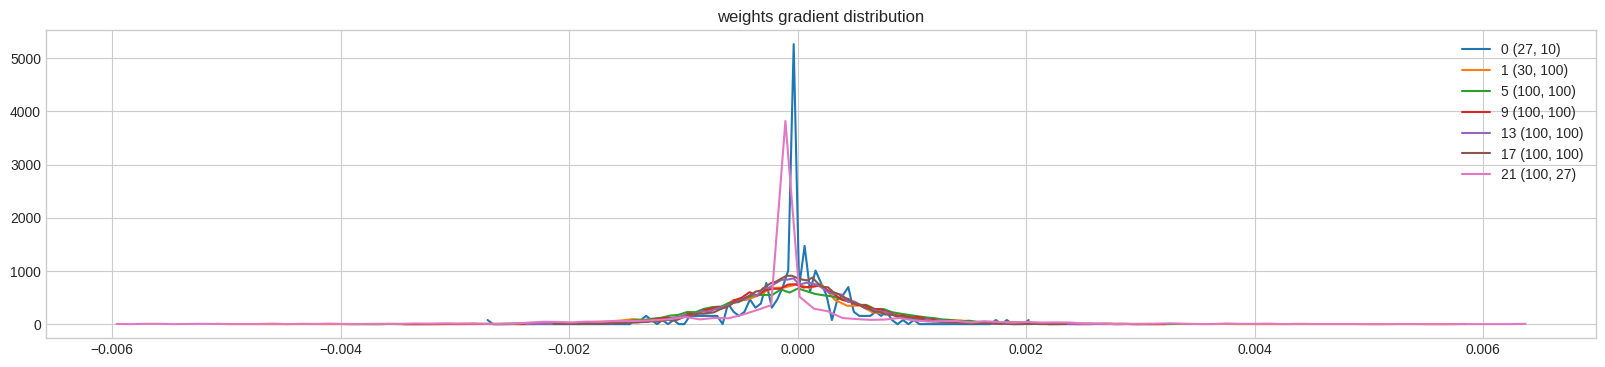

In [70]:
# visualize histogram
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            f"weight {tuple(p.shape)}: mean {t.mean():.6f}, std {t.std():.6f}, grad:data ratio: {t.std() / p.std():.6f}"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(t.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution")
plt.show()

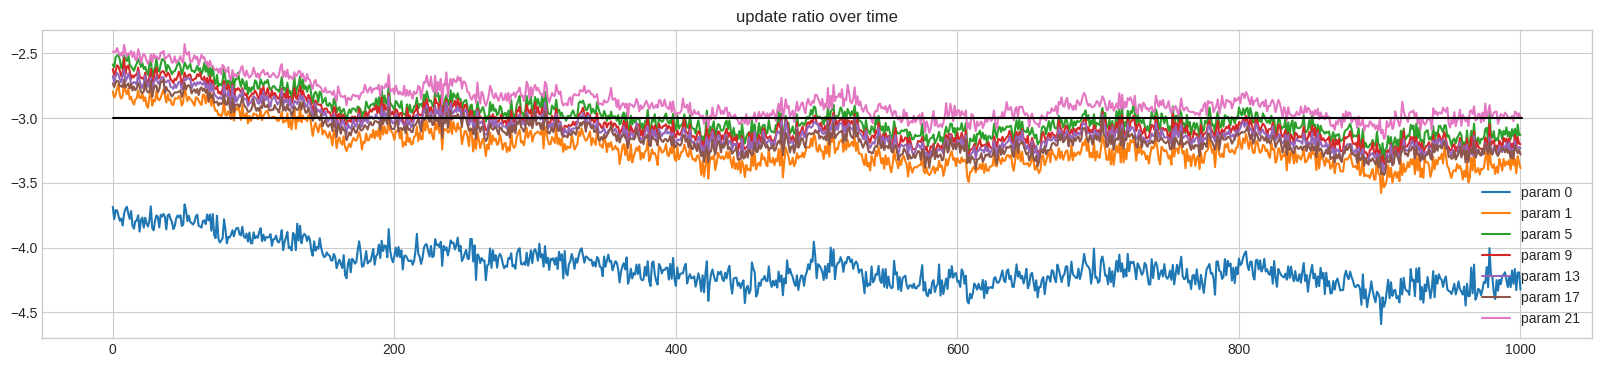

In [71]:
# visualize histogram
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"param {i}")
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.title("update ratio over time")
plt.show()